# Helpful Reviews Machine Learning Tests

This notebook presents an outline of functions and tests that were utilized to select a machine learning model to predict helpful reviews. The number of rows has been limited in order to expedite speed. Tests run with millions of rows gave similar results.

In [1]:
ROWS = 250000

In [2]:
# Import essentials
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def helpful_reviews_pipeline(nrows=500000, subset=True):
    
    # Open Dataframe
    if subset:
        df = pd.read_csv('df_10.csv', nrows=nrows)
    else:
        df = pd.read_csv('df_10.csv')
        
    # Rename column error
    df.rename(columns={'Helpful?': 'Helpful'}, inplace=True)
    
    # Cut Middle Rows
    df = cut_middle_rows(df)
    
    # Choose relevant columns
    df = df[['reviewText', 'Helpful']]
            
    return df

In [4]:
# Define function to eliminate middle rows
def cut_middle_rows(df, high=0.90, low=0.5, hand_pick=True):

    if not hand_pick:
        high = df['Helpful_Rating'].median() + MIDDLEPERCENTAGE*0.25
        low = df['Helpful_Rating'].median() - MIDDLEPERCENTAGE*0.75

    df = df[(df['Helpful_Rating']<low) | (df['Helpful_Rating']>high)]
    
    print('Length of new dataframe: ', len(df), 'rows.')
    
    return df

## Make Corpus

In [5]:
def make_corpus(df):
    
    def normalize_document(doc):
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
        doc = doc.lower()
        doc = doc.strip()
        # tokenize document
        tokens = wpt.tokenize(doc)
        # filter stopwords out of document
        filtered_tokens = [token for token in tokens if token not in stop_words]
        # re-create document from filtered tokens
        doc = ' '.join(filtered_tokens)
        return doc
    
    nltk.download('stopwords')

    wpt = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')

    corpus = df['reviewText']
    normalize_corpus = np.vectorize(normalize_document)
    norm_corpus = normalize_corpus(corpus)
    
    return norm_corpus

## X,y Functions

In [6]:
def make_xy(df, vectorizer):
    vectorizer = vectorizer
    X = vectorizer.fit_transform(df.reviewText)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df['Helpful']
    return X, y

def make_xy_norm(df, vectorizer, norm_corpus):
    vectorizer = vectorizer
    X = vectorizer.fit_transform(norm_corpus)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df['Helpful']
    return X, y

## Test Function

In [7]:
def run_tests(df, ml_test, vectorizer):
    X,y = make_xy(df, vectorizer)
    ml_test(X,y)
    
def run_norm_tests(df, ml_test, vectorizer, norm_corpus):
    X,y = make_xy_norm(df, vectorizer, norm_corpus)
    ml_test(X,y)

## Initial Test Function

In [8]:
# Create function to return the results of machine learning tests
def ml_classification_initial_tests(X, y, test_pct=0.15):
        
    #------------------------------------------------------------------------
    
    # NAIVE BAYES
    print('\nNAIVE BAYES')
    
    # Create a multinomial classifier
    mnb = MultinomialNB()
        
    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = cross_val_score(mnb, X, y, cv=5)

    # Print the 5-fold cross-validation scores
    print(cv_scores)

    print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
    
    #------------------------------------------------------------------------

    
    # LOGISTIC REGRESSION
    print('\nLOGISTIC REGRESSION')

    # Instantiate a logistic regression classifier: logreg
    lr = LogisticRegression()

    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = cross_val_score(lr, X, y, cv=5)

    # Print the 5-fold cross-validation scores
    print(cv_scores)

    print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
    
    
    #------------------------------------------------------------------------
    
    # DECISION TREE TUNED
    print('\nDECISION TREE')
    
    # Instantiate a Decision Tree classifier
    dt = DecisionTreeClassifier()
        
    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = cross_val_score(dt, X, y, cv=5)

    # Print the 5-fold cross-validation scores
    print(cv_scores)

    print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
    
    #------------------------------------------------------------------------
    
    # RANDOM FORESTS
    print('\nRANDOM FORESTS')
    
    # Instantiate a Random Forest Classifier
    rfc = RandomForestClassifier()
    
    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = cross_val_score(rfc, X, y, cv=5)

    # Print the 5-fold cross-validation scores
    print(cv_scores)

    print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

## Initial Tests

In [9]:
def split_data(ROWS, pipeline):
    
    df = pipeline(nrows=ROWS)
    
    split = int(len(df)*0.9)
    
    df_train = df[:split]
    print('Length of df_train:', len(df_train))
    
    df_test = df[split:]
    print('Length of df_test:', len(df_test))
    
    return df_train, df_test

In [10]:
df_train, df_test = split_data(ROWS, helpful_reviews_pipeline)

Length of new dataframe:  104328 rows.
Length of df_train: 93895
Length of df_test: 10433


In [11]:
norm_corpus = make_corpus(df_train)
run_tests(df_train, ml_classification_initial_tests, CountVectorizer())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/coreyjwade/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

NAIVE BAYES
[0.84792332 0.86170723 0.8604292  0.8412056  0.83805517]
Average 5-Fold CV Score: 0.8498641049240987

LOGISTIC REGRESSION
[0.87593184 0.8904095  0.88401938 0.87326269 0.87096602]
Average 5-Fold CV Score: 0.8789178873654795

DECISION TREE
[0.81395101 0.82453805 0.82075723 0.81559188 0.81872404]
Average 5-Fold CV Score: 0.8187124423348108

RANDOM FORESTS
[0.85969116 0.86165398 0.85776665 0.85595612 0.85403131]
Average 5-Fold CV Score: 0.8578198449347934


Naive Bayes, Logistic Regression and Random Forests are all worth pursuing going forward.

## HyperParameter Tests

In [12]:
# Create function to return the results of machine learning tests
def ml_classification_tests(X, y, test_pct=0.15):
        
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_pct)
    
    #------------------------------------------------------------------------
    
    # NAIVE BAYES
    print('\nNAIVE BAYES')
    
    #the grid of parameters to search over
    alphas = [0.001, 0.01, .1, 1, 5]
    
    param_grid = {'alpha': alphas}
    
    # Create a multinomial classifier
    mnb = MultinomialNB()
    
    mnb_cv = GridSearchCV(mnb, param_grid, cv=5)
    
    # Fit the classifier to the data
    mnb_cv.fit(X_train, y_train)
    
    # Print the tuned parameters and score
    print("Best Naive Bayes alpha: {}".format(mnb_cv.best_params_)) 
    print("Best Naive Bayes score: {}".format(mnb_cv.best_score_))
    
    # Predict the labels of the test set: y_pred
    y_pred = mnb_cv.predict(X_test)

    # Compute and print the confusion matrix and classification report
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
    print('Classification Report:', classification_report(y_test, y_pred))
    
    #------------------------------------------------------------------------
    
    # LOGISTIC REGRESSION
    print('\nLOGISTIC REGRESSION')
    
    # Setup the hyperparameter grid
    c_space = np.logspace(-5, 8, 10)
    param_grid = {'C': c_space}

    # Instantiate a logistic regression classifier: logreg
    logreg = LogisticRegression()

    # Instantiate the GridSearchCV object: logreg_cv
    logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

    # Fit it to the data
    logreg_cv.fit(X_train,y_train)

    # Print the tuned parameters and score
    print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
    print("Best Logistic Regression score: {}".format(logreg_cv.best_score_))
    
        # Predict the labels of the test set: y_pred
    y_pred = logreg_cv.predict(X_test)

    # Compute and print the confusion matrix and classification report
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
    print('Classification Report:', classification_report(y_test, y_pred))    
   
    #------------------------------------------------------------------------
    
    # RANDOM FORESTS
    print('\nRANDOM FORESTS')
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}    
    
    # Instantiate a Random Forest Classifier
    rfc = RandomForestClassifier()
    
    # Instantiate RandomizedSearchCV
    rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, cv = 5, n_jobs = -1, n_iter=5)
    
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    # Print the tuned parameters and score
    print("Tuned Random Forest Parameters: {}".format(rf_random.best_params_))
    print("Best Random Forest score: {}".format(rf_random.best_score_))
    
    # Predict the labels of the test set: y_pred
    y_pred = mnb_cv.predict(X_test)

    # Compute and print the confusion matrix and classification report
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
    print('Classification Report:', classification_report(y_test, y_pred))

In [13]:
run_tests(df_train, ml_classification_tests, CountVectorizer())


NAIVE BAYES
Best Naive Bayes alpha: {'alpha': 1}
Best Naive Bayes score: 0.8594286430271896
Confusion Matrix: [[ 1589  1270]
 [  633 10593]]
Classification Report:              precision    recall  f1-score   support

          0       0.72      0.56      0.63      2859
          1       0.89      0.94      0.92     11226

avg / total       0.86      0.86      0.86     14085


LOGISTIC REGRESSION
Tuned Logistic Regression Parameters: {'C': 0.007742636826811269}
Best Logistic Regression score: 0.9002380654053377
Confusion Matrix: [[ 2024   835]
 [  516 10710]]
Classification Report:              precision    recall  f1-score   support

          0       0.80      0.71      0.75      2859
          1       0.93      0.95      0.94     11226

avg / total       0.90      0.90      0.90     14085


RANDOM FORESTS
Tuned Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}
Best Random Fores

Logistic Regression is clearly outperforming Random Forests and Naive Bayes with C=0.007742636826811269.

The logistic regression function below can be used for subsequent tests. The Confusion Matrix is essential due to the class imbalance.

In [14]:
def logistic_regression(X, y, test_pct=0.15):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_pct)
    
    # LOGISTIC REGRESSION
    print('\nLOGISTIC REGRESSION')

    # Instantiate a logistic regression classifier: logreg
    logreg = LogisticRegression(C=0.007742636826811269)

    # Fit it to the data
    logreg.fit(X_train,y_train)
    
    # Predict the labels of the test set: y_pred
    y_pred = logreg.predict(X_test)

    # Compute and print the confusion matrix and classification report
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
    print('Classification Report:', classification_report(y_test, y_pred))
    
    return logreg

## Choose Vectorizer

For each standard vectorizer, CountVectorizer, and TfidfVectorizer, there are various n_gram options.

In [15]:
def choose_vectorizer(df, ml_test, norm_corpus):
    vectorizers = [CountVectorizer(), CountVectorizer(ngram_range=(1,2)), CountVectorizer(ngram_range=(1,3)), TfidfVectorizer(), TfidfVectorizer(ngram_range=(1, 2)), TfidfVectorizer(ngram_range=(1, 3)) ]
    for vect in vectorizers:
        print(str(vect))
        print('\nmake_xy')
        run_tests(df, ml_test, vect)
        print('\nmake_xy_norm')
        run_norm_tests(df, ml_test, vect, norm_corpus)
        print('\n')

In [16]:
choose_vectorizer(df_train, logistic_regression, norm_corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

make_xy

LOGISTIC REGRESSION
Confusion Matrix: [[ 1941   874]
 [  500 10770]]
Classification Report:              precision    recall  f1-score   support

          0       0.80      0.69      0.74      2815
          1       0.92      0.96      0.94     11270

avg / total       0.90      0.90      0.90     14085


make_xy_norm

LOGISTIC REGRESSION
Confusion Matrix: [[ 1925   930]
 [  474 10756]]
Classification Report:              precision    recall  f1-score   support

          0       0.80      0.67      0.73      2855
          1       0.92      0.96      0.94     11230

avg / total       0.90      0.90      0.

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



LOGISTIC REGRESSION
Confusion Matrix: [[    0  2884]
 [    0 11201]]
Classification Report:              precision    recall  f1-score   support

          0       0.00      0.00      0.00      2884
          1       0.80      1.00      0.89     11201

avg / total       0.63      0.80      0.70     14085


make_xy_norm


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



LOGISTIC REGRESSION
Confusion Matrix: [[    0  2753]
 [    0 11332]]
Classification Report:              precision    recall  f1-score   support

          0       0.00      0.00      0.00      2753
          1       0.80      1.00      0.89     11332

avg / total       0.65      0.80      0.72     14085



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

make_xy

LOGISTIC REGRESSION
Confusion Matrix: [[    0  2872]
 [    0 11213]]
Classification Report:              precision    recall  f1-score   support

          0       0.00      0.00      0.00      2872
          1       0.80      1.00  

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



LOGISTIC REGRESSION
Confusion Matrix: [[    0  2787]
 [    0 11298]]
Classification Report:              precision    recall  f1-score   support

          0       0.00      0.00      0.00      2787
          1       0.80      1.00      0.89     11298

avg / total       0.64      0.80      0.71     14085





make_xy is consistently outperforming make_xy-norm. CountVectorizer(n_gram=(1,3)) is currently best, but CountVectorizer(n_gram=(1,2)) is close and faster.

(There was an error in this round with TfidfVectorizer. It shouldn't be 0. In previous tests it underperformed against CountVectorizer, but it can be checked later.)

## Vectorizer Parameters

Logistic regression has a min_df parameter that can be tuned to obtain better results. When between 0 and 1, it discounts the percentage of frequency of words. For instance, df_min = 0.01 would discount words that appear in less than 1% of documents.

In [17]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [18]:
# Define Cumulative Frequency function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [19]:
# Turn X (df.reviewText) into one dimensional array
def sort_reviews_into_1D_list(df, vectorizer):
    X = vectorizer.fit_transform(df.reviewText)
    review_list = list(sorted((X > 0).sum(axis=0).reshape(-1).tolist()[0]))
    return review_list

In [20]:
review_list = sort_reviews_into_1D_list(df_train, CountVectorizer(ngram_range=(1,2)))

#### Graph Word Frequency

Text(0.5,1,'Word Frequency')

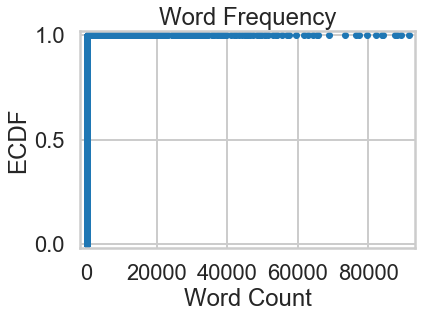

In [21]:
# Compute ECDF
x1, y1 = ecdf(review_list)

# Generate plot
plt.plot(x1, y1, marker='.', linestyle='none')

# Make the margins nice
plt.margins(.02)

# Label the axes
plt.xlabel('Word Count')
plt.ylabel('ECDF')
plt.title('Word Frequency')

(0, 80)

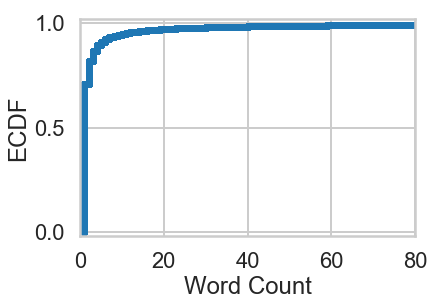

In [22]:
# Generate reduced plot
plt.plot(x1, y1, marker='.', linestyle='none')

# Make the margins nice
plt.margins(.02)

# Label the axes
plt.xlabel('Word Count')
plt.ylabel('ECDF')

#Limit axes
plt.xlim(0,80)

(0, 20)

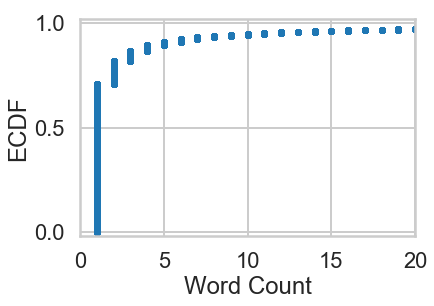

In [23]:
# Generate reduced plot
plt.plot(x1, y1, marker='.', linestyle='none')

# Make the margins nice
plt.margins(.02)

# Label the axes
plt.xlabel('Word Count')
plt.ylabel('ECDF')

#Limit axes
plt.xlim(0,20)

The graph above indicates that 70% of the distinct one and two-word combinations in the entire corpus only appear once. The graph suggests that we try df_mins of 2-10.

A df_min of 2 means that the classifer will discount all words that appear in less than 2 reviews. There is also an option to use percentages.

#### Adjust min_df

In [24]:
def min_df(df, test):
    min_dfs = [1, 2, 3, 4, 6, 8, 10]
    for val in min_dfs:
        vect = CountVectorizer(ngram_range=(1,2), min_df=val)
        print(vect)
        run_tests(df, test, vect)
        print('\n')

In [25]:
min_df(df_train, logistic_regression)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

LOGISTIC REGRESSION
Confusion Matrix: [[ 2108   806]
 [  493 10678]]
Classification Report:              precision    recall  f1-score   support

          0       0.81      0.72      0.76      2914
          1       0.93      0.96      0.94     11171

avg / total       0.91      0.91      0.91     14085



CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(

The best results comes from min_df = 2, and min_df=6.

#### Max Graphs

I will use the new dataset, df_overall_2, to determine a max_df since it's larger than the previous dataset. A max_df of 0.99 would discount words that appear in more than 99% of all documents, presumably words like 'a', 'the', and other common words.

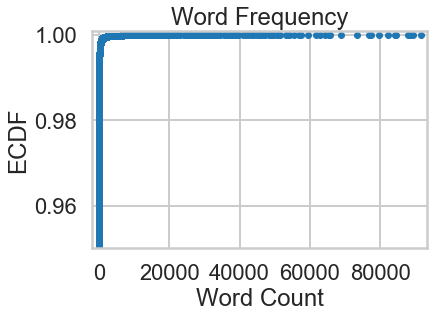

In [26]:
# Generate max plot
plt.plot(x1, y1, marker='.', linestyle='none')

# Make the margins nice
plt.margins(.02)

# Label the axes
plt.xlabel('Word Count')
plt.ylabel('ECDF')
plt.title('Word Frequency')

#Limit axes
plt.ylim(0.95, 1.001)
plt.show()

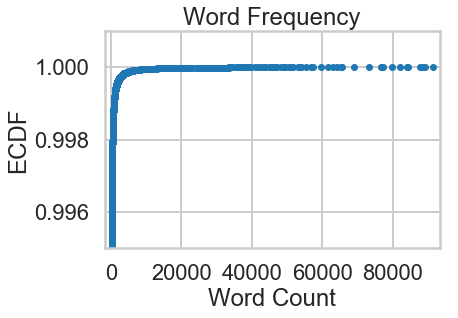

In [27]:
# Generate zoom plot
plt.plot(x1, y1, marker='.', linestyle='none')

# Make the margins nice
plt.margins(.02)

# Label the axes
plt.xlabel('Word Count')
plt.ylabel('ECDF')
plt.title('Word Frequency')

#Limit axes
plt.ylim(0.995, 1.001)
plt.show()

The graph really changes at around 0.999

#### Test Percentages

In [28]:
def max_df(df, test):
    max_dfs = [0.9, 0.99, 0.999, 0.9999, 1.0]
    for val in max_dfs:
        vect = CountVectorizer(ngram_range=(1,2), max_df=val)
        print(vect)
        run_tests(df, test, vect)
        print('\n')

In [29]:
max_df(df_train, logistic_regression)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

LOGISTIC REGRESSION
Confusion Matrix: [[ 2055   835]
 [  525 10670]]
Classification Report:              precision    recall  f1-score   support

          0       0.80      0.71      0.75      2890
          1       0.93      0.95      0.94     11195

avg / total       0.90      0.90      0.90     14085



CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='

The best results for df_train are max_df=1.0. 

## Evaluate Combined Model

In [31]:
from sklearn.externals import joblib

def log_reg_fin(X, y):
        
    lr = LogisticRegression(C=0.007742636826811269)
    
    lr.fit(X, y)
    
    scores = cross_val_score(lr, X, y, cv=5)

    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
    predicted = cross_val_predict(lr, X, y, cv=5)
    
    report = classification_report(y, predicted) 
    
    print('\n')    
    print(report)
    
    joblib.dump(lr, 'lr_model.pkl')
    print('Logistic Regression model saved as "lr_model.pkl"')
    
    return lr

In [32]:
run_tests(df_train, log_reg_fin, CountVectorizer(ngram_range=(1,3), max_df=1.0, min_df=2))

Accuracy: 0.90 (+/- 0.01)


             precision    recall  f1-score   support

          0       0.79      0.71      0.75     19006
          1       0.93      0.95      0.94     74889

avg / total       0.90      0.90      0.90     93895

Logistic Regression model saved as "lr_model.pkl"


In [33]:
run_tests(df_test, log_reg_fin, CountVectorizer(ngram_range=(1,3), max_df=1.0, min_df=2))

Accuracy: 0.88 (+/- 0.03)


             precision    recall  f1-score   support

          0       0.77      0.54      0.63      2084
          1       0.89      0.96      0.92      8349

avg / total       0.87      0.88      0.87     10433

Logistic Regression model saved as "lr_model.pkl"


## Star Tests

It's worth running the same tests to try and determine if someone likes or dislikes a book basked on the review. This can translate directly to the number of stars given.

#### Create Stars Column (binary)

In [ ]:
df_10 = pd.read_csv('df_10.csv')

In [ ]:
# Define function
def stars(row):
    # Give 1 star reviews a value of 0
    if row['overall']==1:
        return 0
    # Give 2 star reviews a value of 0
    elif row['overall']==2:
        return 0
    # Give 3 star reviews a value of 0
    elif row['overall']==3:
        return 0
    # Give 4,5 star reviews a value of 0
    else:
        return 1

# Create column
df_10['Stars'] = df_10.apply(stars, axis=1)

In [ ]:
# Save updated file
df_10.to_csv('df_10.csv')

In [ ]:
# Define new dataframe that eliminates the middle, 3 and 4-star reviews
#df_stars = df_10[(df_10['overall']!=3) | (df_10['overall']!=4)]
df_stars = df_10[(df_10['overall']!=3)]

# Save updated file
df_stars.to_csv('df_stars.csv')

In [34]:
def star_reviews_pipeline(nrows=10000, subset=True):
    
    # Open Dataframe
    if subset:
        df = pd.read_csv('df_stars.csv', nrows=nrows)
    else:
        df = pd.read_csv('df_stars.csv')
    
    # Choose relevant columns
    df = df[['reviewText', 'Stars']]
            
    return df

#### Adjust Functions for Initial Tests

In [35]:
def make_xy_stars(df, vectorizer):
    vectorizer = vectorizer
    X = vectorizer.fit_transform(df.reviewText)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.Stars
    return X, y

In [36]:
def run_star_tests(df, ml_test, vectorizer):
    X,y = make_xy_stars(df, vectorizer)
    ml_test(X,y)

#### Initial Test

In [37]:
df_train_stars, df_test_stars = split_data(ROWS, star_reviews_pipeline)

Length of df_train: 225000
Length of df_test: 25000


In [38]:
run_star_tests(df_train_stars, logistic_regression, CountVectorizer(ngram_range=(1,2)))


LOGISTIC REGRESSION
Confusion Matrix: [[10024  1651]
 [ 1099 20976]]
Classification Report:              precision    recall  f1-score   support

          0       0.90      0.86      0.88     11675
          1       0.93      0.95      0.94     22075

avg / total       0.92      0.92      0.92     33750



In [39]:
run_star_tests(df_test_stars, logistic_regression, CountVectorizer(ngram_range=(1,2)))


LOGISTIC REGRESSION
Confusion Matrix: [[1130  279]
 [ 113 2228]]
Classification Report:              precision    recall  f1-score   support

          0       0.91      0.80      0.85      1409
          1       0.89      0.95      0.92      2341

avg / total       0.90      0.90      0.89      3750



This is definitely worth pursuing going forward.

## Results

Best result for Helpful Reviews:
LogisticRegression(C=0.007742636826811269)
CountVectorizer(ngram_range=(1,2))
Precision, Recall and F1 Scores: 91%, 91%, 91%
Test Set: 87, 88, 87

Best result for Stars: 
LogisticRegression(C=0.007742636826811269)
CountVectorizer(ngram_range=(1,2))
Precision, Recall and F1 Scores: 92%, 92%, 92%

The results are very compelling. With minimal hyperparameter tweaking, logistic regression reaches 90% accuracy with CountVectorizer(ngram_range=(1,2)). Multiple tests revealed similar results. Options worth considering going forward include CountVectorizer(ngram_range=1,2) and CountVectorizer(ngram_range=1,3) with min_df = 2, or 1 and max_df = 0.9999 or 1. 

Of additional note is that make_xy outperforms make_xy_norm. This means that corpus generated by CountVectorizer does better than the normed corpus I created.